In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

In [2]:
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2022-07-07 04:47:34--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  4.12MB/s    in 1.6s    

2022-07-07 04:47:37 (4.12 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



In [1]:
from mmdet.apis import init_detector, inference_detector 
import mmcv 

In [2]:
import os 
import cv2 
import sys 
import mmcv 
import mmdet 
import torch 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os.path as osp 
import copy

In [3]:
from mmdet.apis import init_detector, inference 
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset
from mmdet.apis import set_random_seed
from mmcv import Config

In [4]:
def show_version():
    print(f"cv2 version {cv2.__version__}")
    print(f"numpy version {np.__version__}")    
    print(f"pandas version {pd.__version__}")    
    print(f"torch version {torch.__version__}")    
    print(f"python version {sys.version}")    
    print(f"mmdet version {mmdet.__version__}")

In [5]:
show_version()

cv2 version 4.1.2
numpy version 1.21.6
pandas version 1.3.5
torch version 1.11.0+cu113
python version 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
mmdet version 2.25.0


In [6]:
# @DATASETS.register_module(force=True)
# class KittyTinyDataset(CustomDataset):
#     CLASSES = ("Car", "Truck", "Pedestrian", "Cyclist")

#     def load_annotation(self, ann_file):
#         print(f"self.data_root : {self.data_root} \nself.ann_file : {self.ann_file}, \nself.img_prefix {self.img_prefix}")
#         cat2label = {k:i for i, k in enumerate(self.CLASSES)}
#         image_list = mmcv.list_from_file(self.ann_file)

#         data_info = [] 

#         for image_id in image_list : 
#             filename = "{0:}{1:}.jpeg".format(self.img_prefix, image_id)
#             image = cv2.imread(filename)
#             height, width = image.shape[:2]

#             data_info = {"filename":str(image_id)+"jpeg",
#                          "width" : width, 
#                          "height": height
#             } 

#             label_prefix = self.img_prefix.replace("image_2", "label_2")
#             lines = mmcv.list_from_file(osp.join(label_prefix, str(image_id)+".txt"))
 
#             content = [line.strip().split(" ") for line in lines]

#             bbox_names = [x[0] for x in content]
#             bboxes = [[float(info) for info  in x[4:8]] for x in content]
            
#             gt_bboxes = []
#             gt_labels = []
#             gt_bboxes_ignore = []
#             gt_labels_ignore = [] 

#             for bbox_name, bbox in zip(bbox_name, bboxes):
#                 if bbox_name in cat2label:
#                     gt_bboxes.append(bbox)
#                     gt_labels.append(cat2label[bbox_name])
#                 else:
#                     gt_bboxes_ignore.append(bbox)
#                     gt_labels_ignore.append(-1)
            
#             data_anno = {
#                 "bboxes":np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4), 
#                 "labels":np.array(gt_labels, dtype=np.long),
#                 "bboxes_ignore" : np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
#                 "labels_ignore" : np.array(gt_labels_ignore, dtype=np.long)
#             }

#             data_info.update(ann=data_anno)

#             data_infos.append(data_info)

#         return data_infos




In [7]:
import copy
import os.path as osp
import cv2

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module(force=True)
class KittyTinyDataset(CustomDataset):
  CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
  

  def load_annotations(self, ann_file):
    print('##### self.data_root:', self.data_root, 'self.ann_file:', self.ann_file, 'self.img_prefix:', self.img_prefix)
    print('#### ann_file:', ann_file)
    cat2label = {k:i for i, k in enumerate(self.CLASSES)}
    image_list = mmcv.list_from_file(self.ann_file)

    data_infos = []
    
    for image_id in image_list:
      filename = '{0:}/{1:}.jpeg'.format(self.img_prefix, image_id)

      image = cv2.imread(filename)
      height, width = image.shape[:2]
      data_info = {'filename': str(image_id) + '.jpeg',
                   'width': width, 'height': height}
      label_prefix = self.img_prefix.replace('image_2', 'label_2')
      lines = mmcv.list_from_file(osp.join(label_prefix, str(image_id)+'.txt'))

      content = [line.strip().split(' ') for line in lines]
      bbox_names = [x[0] for x in content]
      bboxes = [ [float(info) for info in x[4:8]] for x in content]

      gt_bboxes = []
      gt_labels = []
      gt_bboxes_ignore = []
      gt_labels_ignore = []

      for bbox_name, bbox in zip(bbox_names, bboxes):
        if bbox_name in cat2label:
          gt_bboxes.append(bbox)
          gt_labels.append(cat2label[bbox_name])
        else:
          gt_bboxes_ignore.append(bbox)
          gt_labels_ignore.append(-1)

      data_anno = {
          'bboxes': np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
          'labels': np.array(gt_labels, dtype=np.long),
          'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
          'labels_ignore': np.array(gt_labels_ignore, dtype=np.long)
      }
      data_info.update(ann=data_anno)
      data_infos.append(data_info)

    return data_infos


In [8]:
config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [9]:
!cd mmdetection; mkdir checkpoints
!wget -O /content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

--2022-07-07 04:48:20--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

/content/mmdetectio 100%[===================>] 159.54M  7.91MB/s    in 21s     

2022-07-07 04:48:42 (7.69 MB/s) - ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [11]:
cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [12]:
from mmdet.apis import set_random_seed

cfg.dataset_type = 'KittyTinyDataset'
cfg.data_root = '/content/kitti_tiny/'

cfg.data.train.type = 'KittyTinyDataset'
cfg.data.train.data_root = '/content/kitti_tiny/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittyTinyDataset'
cfg.data.val.data_root = '/content/kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

cfg.data.test.type = 'KittyTinyDataset'
cfg.data.test.data_root = '/content/kitti_tiny/'
cfg.data.test.ann_file = 'val.txt'
cfg.data.test.img_prefix = 'training/image_2'

cfg.model.roi_head.bbox_head.num_classes = 4
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

cfg.work_dir = './tutorial_exps'

cfg.optimizer.lr = 0.02 / 8

cfg.lr_config.warmup = None
cfg.log_config.interval = 10

cfg.lr_config.policy = 'step'

cfg.evaluation.metric = 'mAP'
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12

cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = "cuda"

print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

In [15]:
from mmdet.apis import set_random_seed


cfg.dataset_type = 'KittyTinyDataset'
cfg.data_root = '/content/kitti_tiny/'

cfg.data.train.type = 'KittyTinyDataset'
cfg.data.train.data_root = '/content/kitti_tiny/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittyTinyDataset'
cfg.data.val.data_root = '/content/kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

cfg.data.test.type = 'KittyTinyDataset'
cfg.data.test.data_root = '/content/kitti_tiny/'
cfg.data.test.ann_file = 'val.txt'
cfg.data.test.img_prefix = 'training/image_2'

cfg.model.roi_head.bbox_head.num_classes = 4
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

cfg.work_dir = './tutorial_exps'
cfg.optimizer.lr = 0.02 / 8

cfg.lr_config.warmup = None
cfg.log_config.interval = 10

cfg.lr_config.policy = 'step'

cfg.evaluation.metric = 'mAP'
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12
cfg.device = "cuda"
cfg.data.train.pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations', with_bbox=True),
            dict(type='Resize', img_scale=(1500, 900), keep_ratio=True),
            dict(type='RandomFlip', flip_ratio=0.5),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
        ]

cfg.data.val.pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1500, 900),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='Pad', size_divisor=32),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]
  
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Resize', img_scale=(1500, 900), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1500, 900),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

In [16]:
from mmdet.datasets import build_dataset 
from mmdet.models import build_detector
from mmdet.apis import train_detector 

datasets = [build_dataset(cfg.data.train)]

##### self.data_root: /content/kitti_tiny/ self.ann_file: /content/kitti_tiny/train.txt self.img_prefix: /content/kitti_tiny/training/image_2
#### ann_file: /content/kitti_tiny/train.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int`

In [17]:
datasets

[
 KittyTinyDataset Train dataset with number of images 50, and instance counts: 
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+
 | category | count | category  | count | category       | count | category    | count | category      | count |
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+
 | 0 [Car]  | 147   | 1 [Truck] | 7     | 2 [Pedestrian] | 23    | 3 [Cyclist] | 7     | -1 background | 0     |
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+]

In [18]:
model = build_detector(cfg.model, train_cfg=cfg.get("train_cfg"), test_cfg=cfg.get("test_cfg"))
model.CLASSES = datasets[0].CLASSES

In [19]:
%cd mmdetection

/content/mmdetection


In [20]:
pwd

'/content/mmdetection'

In [21]:
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

In [22]:
train_detector(model, datasets, cfg, distributed=False, validate=True)

2022-07-07 04:49:40,815 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by i

##### self.data_root: /content/kitti_tiny/ self.ann_file: /content/kitti_tiny/val.txt self.img_prefix: /content/kitti_tiny/training/image_2
#### ann_file: /content/kitti_tiny/val.txt


2022-07-07 04:49:41,102 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([5, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([5]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([16, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([16]).
2022-07-07 04:49:41,108 - mmdet - INFO - Start running, host: root@fc1be08dc889, work_dir: /content/mmdetection/tutorial_exps
2022-07-07 04:49:41,110 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH  

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 9.1 task/s, elapsed: 3s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-07-07 04:52:27,836 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 143  | 0.952  | 0.836 |
| Truck      | 3   | 24   | 1.000  | 0.667 |
| Pedestrian | 13  | 51   | 0.846  | 0.720 |
| Cyclist    | 7   | 49   | 0.429  | 0.056 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.570 |
+------------+-----+------+--------+-------+
2022-07-07 04:52:27,840 - mmdet - INFO - Epoch(val) [12][25]	AP50: 0.5700, mAP: 0.5698


/usr/local/lib/python3.7/dist-packages/mmdet-2.25.0-py3.7.egg/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


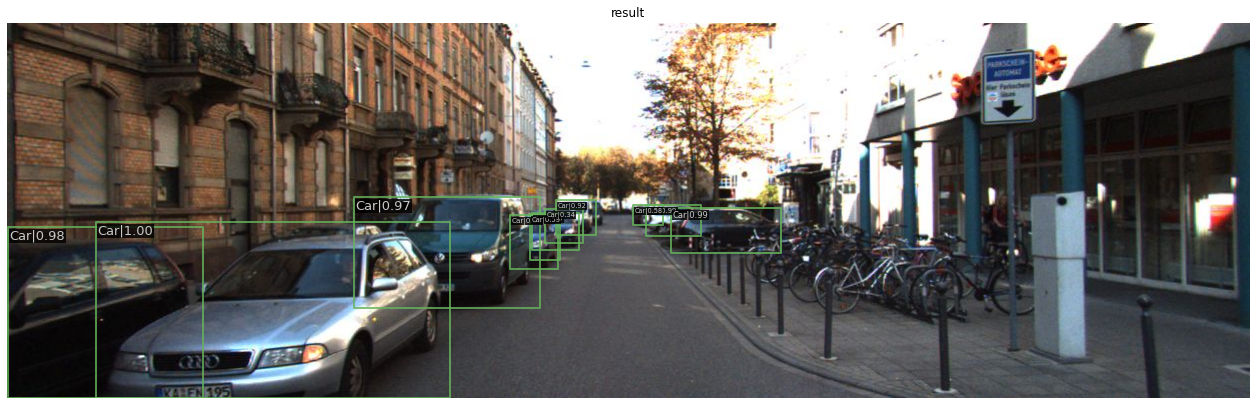

In [23]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

img = cv2.imread('/content/kitti_tiny/training/image_2/000068.jpeg')

model.cfg = cfg

result = inference_detector(model, img)
show_result_pyplot(model, img, result)